In [1]:
import sys
import torch

## 1、关于 a = a
### 这个只是代码验证，没找到理论依据，如果大家有其它观点，欢迎提出来
### 结论：仍然是指向原对象

In [2]:
# 非字符串情况
a = 50000
b = 50000
print(id(a) == id(b))
print(sys.getrefcount(a), sys.getrefcount(b), sys.getrefcount(50000))
a = a  # 这句话完成以后，仍然有3个变量指向a的对象，没有变多
print(sys.getrefcount(a), sys.getrefcount(b), sys.getrefcount(50000))
c = a
print(sys.getrefcount(a), sys.getrefcount(b), sys.getrefcount(50000))

False
3 3 3
3 3 3
4 3 3


In [3]:
# 字符串情况
a = '12346778'
b = '12346'+'778'
print(id(a) == id(b))
# 其实上面这句话已经说明，同一个字符串就是一个对象，不过后面的过程可进一步支持相关结论
print(sys.getrefcount(a), sys.getrefcount(b), sys.getrefcount('12346778'))
a = a
print(sys.getrefcount(a), sys.getrefcount(b), sys.getrefcount('12346778'))
c = a
print(sys.getrefcount(a), sys.getrefcount(b), sys.getrefcount('12346778'))

True
5 5 5
5 5 5
6 6 6


## 2、内积求导
### 应该会有人发现不妥，但没告诉我

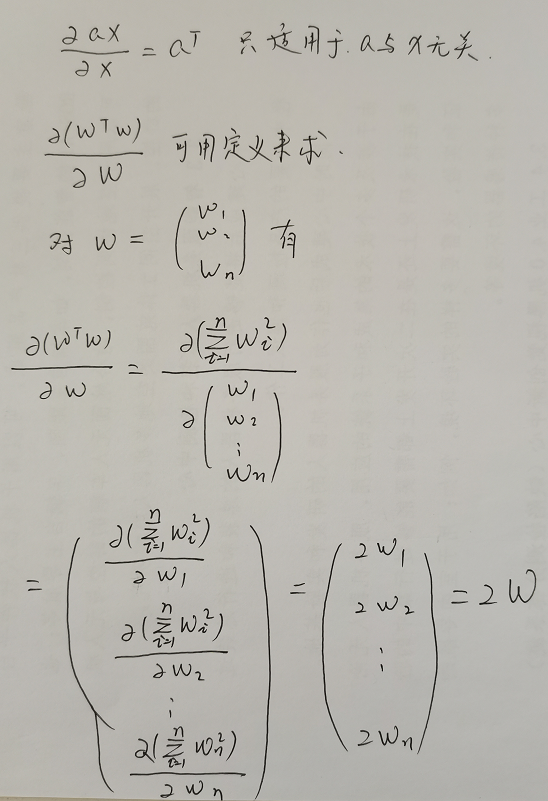

## 3、非叶子结节的 .requires_grad
### 结论1：有这个属性，但是不能改
### 结论2：只有这个属性为真才能传梯度
### 结论3：非叶子结点默认不存梯度，但可以使用 .retain_grad()
### 感谢英豪给提供的思路

### 结论1：有这个属性，但是不能改

In [4]:
# 提供形状的辅助张量
v = torch.eye(2, 2)

In [5]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
print(y.grad_fn) 
print(y.requires_grad)

True


In [6]:
y.requires_grad_(True)  # 可以执行，但没有用 （感兴趣的话可深入探讨torch本地操作的具体机制）

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

In [7]:
y.requires_grad_(False) # 不可以执行

RuntimeError: you can only change requires_grad flags of leaf variables. If you want to use a computed variable in a subgraph that doesn't require differentiation use var_no_grad = var.detach().

In [8]:
y.requires_grad = True  # 这种方式这样都不行

RuntimeError: you can only change requires_grad flags of leaf variables.

In [9]:
y.requires_grad = False  # 意料之中

RuntimeError: you can only change requires_grad flags of leaf variables. If you want to use a computed variable in a subgraph that doesn't require differentiation use var_no_grad = var.detach().

In [10]:
y.backward(v)  # 这是可以传梯度的

### 结论2：只有这个属性为真才能传梯度

In [11]:
x = torch.ones(2, 2, requires_grad=True)
with torch.no_grad():
    y = x + 2
print(y.grad_fn)  # 这种情况下，连函数我也不记了 ==>> 所以，即使放开，改requires_grad也不能构建计算图
print(y.requires_grad)
y.backward(v)

None
False


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

### 结论3：非叶子结点默认不存梯度，但可以使用 .retain_grad()

In [12]:
# 默认不存
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
y.backward(v)
print(y.grad)

None


C:\idk\Anaconda3\lib\site-packages\torch\_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten\src\ATen/core/TensorBody.h:417.)
  return self._grad


In [13]:
# 保存梯度
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
y.retain_grad()
y.backward(v)
print(y.grad)

tensor([[1., 0.],
        [0., 1.]])


In [14]:
# 用哪个存哪个
x = torch.ones(2, 2, requires_grad=True)
z = x * x
y = z + 2
y.retain_grad()
y.backward(v)
print(y.grad, z.grad)

tensor([[1., 0.],
        [0., 1.]]) None


## 4、半路回传：半路回传本身没有问题，但计算图默认只用一次
### 这个确实是个容易犯的错误，大家也可能会遇到

In [15]:
# 直接回传是可行的
x = torch.tensor(1.0, requires_grad=True)
y1 = x ** 3 
y2 = y1 ** 2
    
y1.backward()
print(x.grad)

tensor(3.)


In [16]:
# 但只能用一次（圣斗士星矢？）
y1.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [17]:
# retain_graph=True 即可
x = torch.tensor(1.0, requires_grad=True)
y1 = x ** 3 
y2 = y1 ** 2
    
y1.backward(retain_graph=True)
print(x.grad)
y1.backward() # 如果加上 retain_graph=True 可多次使用
print(x.grad)

tensor(3.)
tensor(6.)
